# Fire Detection Model using YOLOv8
From the publicly available dataset (https://universe.roboflow.com/aj-garcia-736tc/fire-dataset-for-yolov8)

In [8]:
!pip install roboflow ultralytics

In [9]:
import os
import shutil
import re
import matplotlib.pyplot as plt
import cv2

from google.colab import userdata
from roboflow import Roboflow
from pathlib import Path
from ultralytics import YOLO

cur_dataset = None
cur_dataset = 'Detection-Fire--1'

# Download the dataset if it hasnt been downloaded yet
if not os.path.exists(f'./datasets/{cur_dataset}'):
    rf = Roboflow(api_key=userdata.get("ROBOFLOW_API_KEY"))
    project = rf.workspace("is4").project("detection-fire-ljmw2")
    version = project.version(1)
    dataset = version.download("yolov8")

In [10]:
train_path = Path(f'./datasets/{cur_dataset}/train/images')
train_size = len(os.listdir(train_path))

val_path = Path(f'./datasets/{cur_dataset}/valid/images')
val_size = len(os.listdir(val_path))

print(f"Train images size: {train_size}, Val images size: {val_size}")

Train images size: 2055, Val images size: 577


Text(0.5, 1.0, 'Train/ Val Distribution')

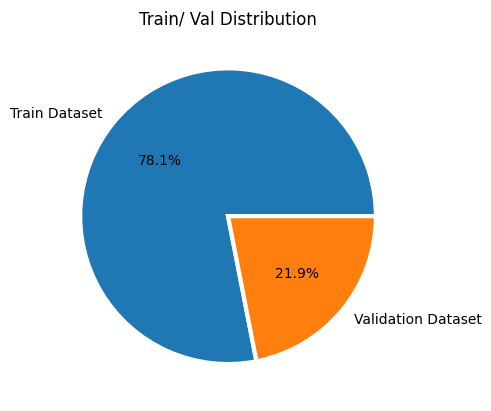

In [11]:
names = ["Train Dataset", "Validation Dataset"]
values = [train_size, val_size]

# Visualize the percentage of the distributed datasets
plt.pie(x=values, labels=names, autopct='%.1f%%', wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'})
plt.title("Train/ Val Distribution")

In [12]:
%cd ~/Documents/Projects/UNI544-SymbIoT-Prototype

[Errno 2] No such file or directory: '/root/Documents/Projects/UNI544-SymbIoT-Prototype'
/content


In [16]:
!yolo task=detect mode=train model=weights/yolov8n.pt data=/content/datasets/{cur_dataset}/data.yaml \
    epochs=150 imgsz=640 batch=64 save=True augment=True patience=20 \
    degrees=3 translate=0.1 scale=0.3 flipud=0.1 fliplr=0.3 optimizer="auto" cos_lr=False

Ultralytics 8.3.121 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=weights/yolov8n.pt, data=/content/datasets/Detection-Fire--1/data.yaml, epochs=150, time=None, patience=20, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

In [17]:
runs_dir = './runs'
# Get the latest results and evaluate them
if os.path.exists(runs_dir):
    all_dirs = os.listdir(os.path.join(runs_dir, 'detect'))

    train_dirs = [dir for dir in all_dirs if re.match("train", dir)]
    last_train = sorted(train_dirs, key=lambda x: (len(x), x))[-1]

    last_weight_path = os.path.join(runs_dir, 'detect', last_train, 'weights/best.pt')

    model = YOLO(last_weight_path)
    metrics = model.val()
    print(metrics.box.map50)

Ultralytics 8.3.121 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 882.4±241.2 MB/s, size: 53.2 KB)


val: Scanning /content/datasets/Detection-Fire--1/valid/labels.cache... 577 images, 0 backgrounds, 0 corrupt: 100%|██████████| 577/577 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:10<00:00,  3.59it/s]


                   all        577        938      0.961      0.902      0.958      0.666
Speed: 1.8ms preprocess, 4.9ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/detect/val
0.9582376795130066


In [18]:
# Current best model
best_model_path = 'runs/detect/train2/weights/best.pt'
# model = YOLO(best_model_path)
# metrics = model.val()
# print(metrics.box.map50)

# Get the val directory and sort them
cur_dirs = os.listdir(os.path.join(runs_dir, 'detect'))
val_dirs = [dir for dir in cur_dirs if re.match("val", dir)]
last_val = sorted(val_dirs, key=lambda x: (len(x), x))[-1]

last_val_path = os.path.join(runs_dir, 'detect', last_val)
last_val_files = os.listdir(last_val_path)

# Get metrics (F1, P, R , PR)
def get_metric_plots():
    metrics_files = [file for file in last_val_files if not re.match("val", file) and not re.match("confusion", file)]

    rows = 2
    cols = 2
    fig  = plt.figure(figsize=(15, 10))

    for i, metric in enumerate(metrics_files):
        img = cv2.cvtColor(cv2.imread(os.path.join(last_val_path, metric)), cv2.COLOR_BGR2RGB)

        fig.add_subplot(rows, cols, i+1)

        plt.imshow(img)
        plt.axis("off")
        plt.title(metric)

def get_confusion_matrix():
    cm_files = [file for file in last_val_files if re.match("confusion", file)]

    rows = 1
    cols = 2
    fig  = plt.figure(figsize=(20, 10))

    for i, cm in enumerate(cm_files):
        img = cv2.cvtColor(cv2.imread(os.path.join(last_val_path, cm)), cv2.COLOR_BGR2RGB)

        fig.add_subplot(rows, cols, i+1)

        plt.imshow(img)
        plt.axis("off")
        plt.title(cm)

def get_val_img_pred_labels():
    val_img_files = [file for file in last_val_files if re.match("val", file)]

    rows = 2
    cols = 3
    fig  = plt.figure(figsize=(20, 10))

    for i, val_img in enumerate(val_img_files):
        img = cv2.cvtColor(cv2.imread(os.path.join(last_val_path, val_img)), cv2.COLOR_BGR2RGB)

        fig.add_subplot(rows, cols, i+1)

        plt.imshow(img)
        plt.axis("off")
        plt.title(val_img)

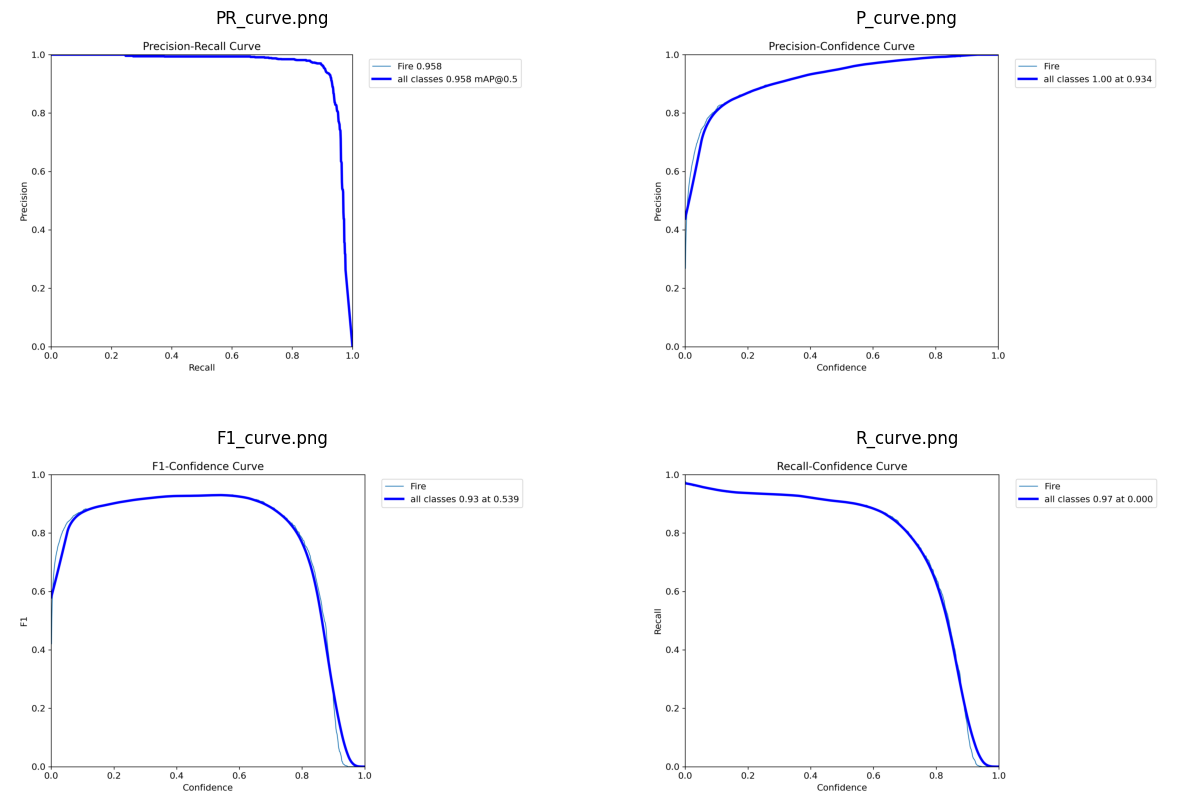

In [19]:
get_metric_plots()

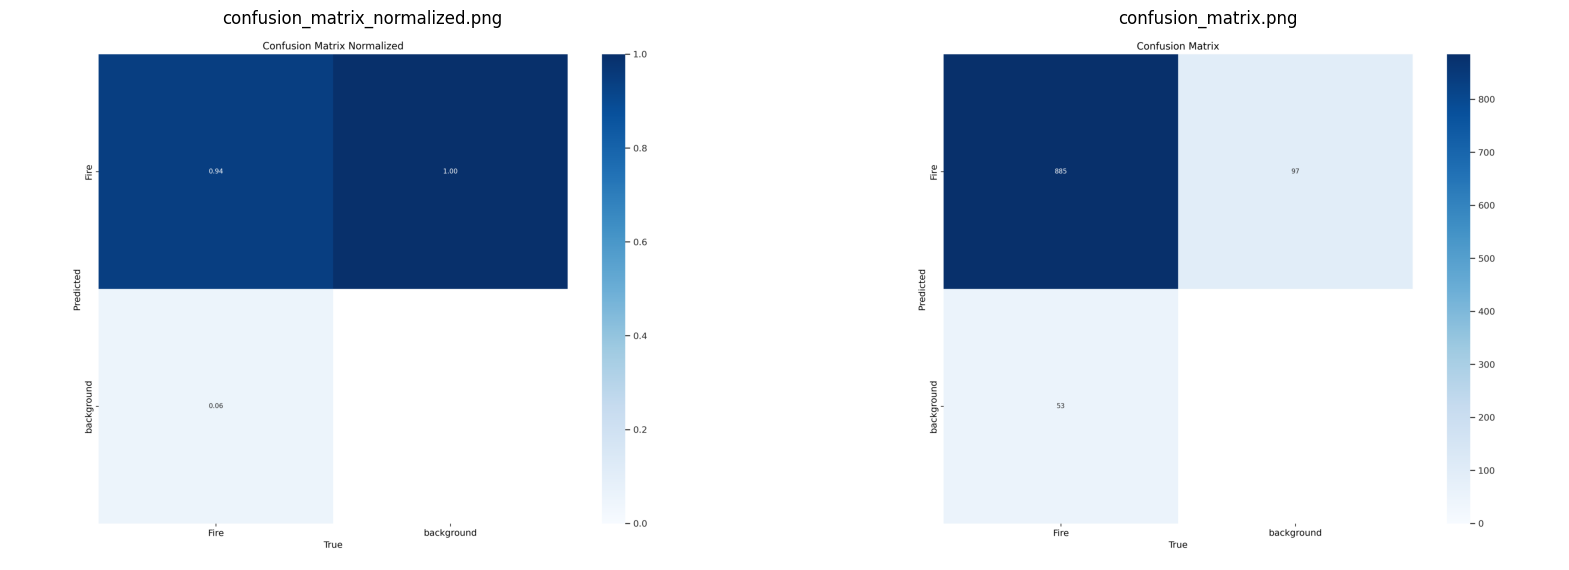

In [20]:
get_confusion_matrix()

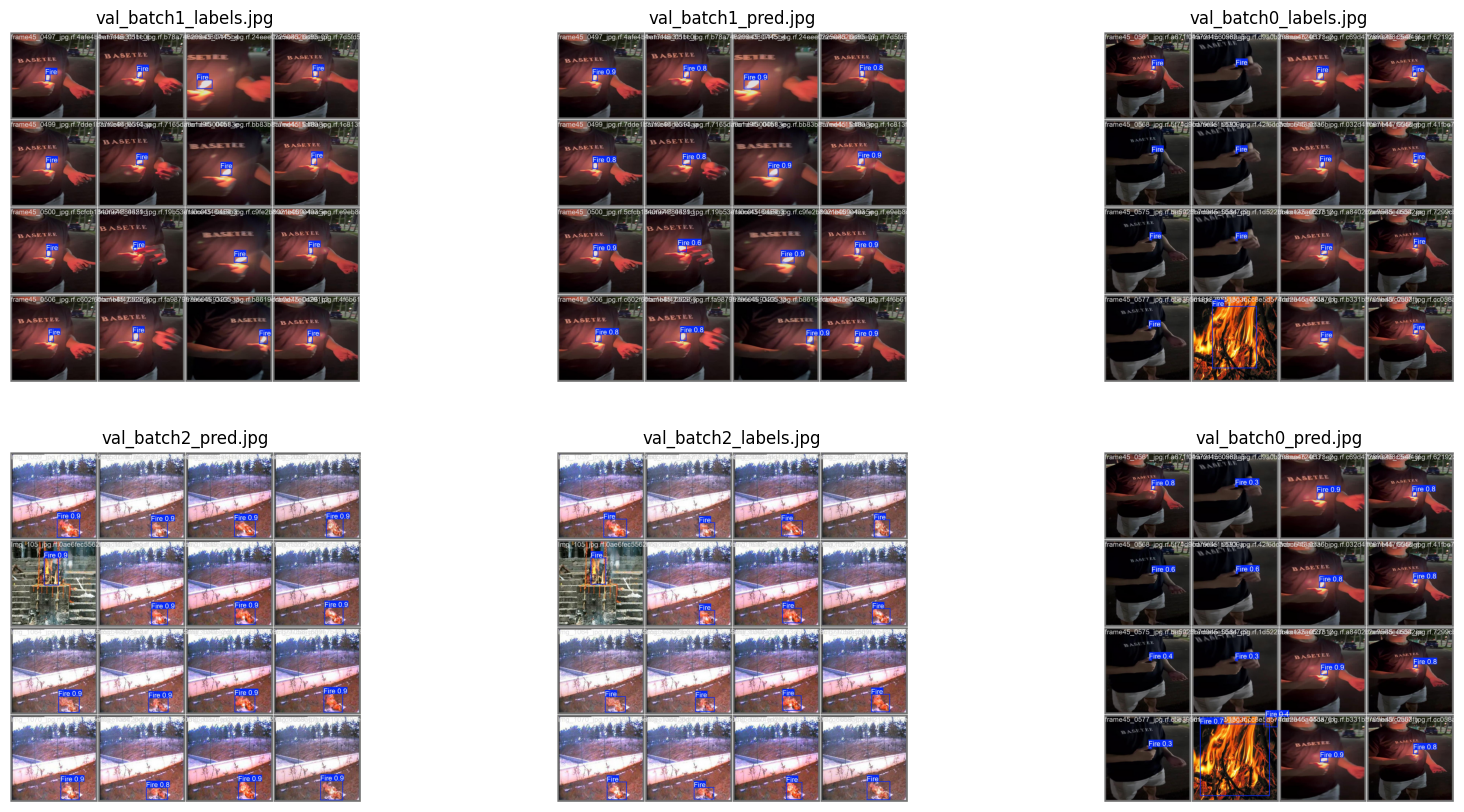

In [21]:
get_val_img_pred_labels()

In [22]:
# Copy best result into output folder
if not os.path.exists('./Output'):
  os.mkdir('./Output')
shutil.copy(best_model_path, './Output/yolo_model.pt')

'./Output/yolo_model.pt'